# 1. Import Libraries

In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [22]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm
tqdm.pandas()

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam 
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    GlobalAveragePooling1D, BatchNormalization, LeakyReLU, Dropout

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Load Data

In [3]:
df = pd.read_csv('news.csv')
df = df.drop(columns=['Unnamed: 0'])
df.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [4]:
df['label'].value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

# 3. Preprocessing Data

### 3.1. Load English Stopwords 

In [10]:
def lower_text(text):
    return text.lower()

def clean_text(text):
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'www\S+', ' ', text)
    text = re.sub("#+"," ", text)
    text = re.sub("@[\w]*"," ", text)
    text = re.sub("[^a-z0-9\s]"," ", text)
    text = re.sub("@[a-z0-9_]+"," ", text)
    return text

def remove_duplicate_words(text):
    return re.sub(r'\b(\w+)(\s+\1)+\b', r'\1', text)

def lemmatizer(text):
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))
    return ''.join(sentence)

stopword_en = pd.read_csv('../en_stopword_1555.txt', header=None).drop_duplicates()
en_stopword = stopword_en[0].values.tolist()
en_stopword = [word.strip() for word in en_stopword]

nltk_stopword = stopwords.words('english')

combined_stopwords = pd.DataFrame(en_stopword + nltk_stopword).drop_duplicates()
stopword_list = combined_stopwords[0].values.tolist()

### 3.2. Remove Stopword from Data

In [11]:
df['clean_text'] = df['text'] \
                    .progress_apply(lower_text) \
                    .progress_apply(lambda x: ' '.join([word for word in x.split() if word not in (nltk_stopword)])) \
                    .progress_apply(clean_text) \
                    .progress_apply(lemmatizer)
df

  0%|          | 0/6335 [00:00<?, ?it/s]

  0%|          | 0/6335 [00:00<?, ?it/s]

  0%|          | 0/6335 [00:00<?, ?it/s]

  0%|          | 0/6335 [00:00<?, ?it/s]

### 3.3. Change label to binary number and Counting the data

In [12]:
df['label'] = [0 if i == 'FAKE' else 1 for i in df['label']]
print(Counter(df['label']))

Counter({1: 3171, 0: 3164})


# 4. Data Exploration

### 4.1. Number of words in each text

<Axes: xlabel='text_len'>

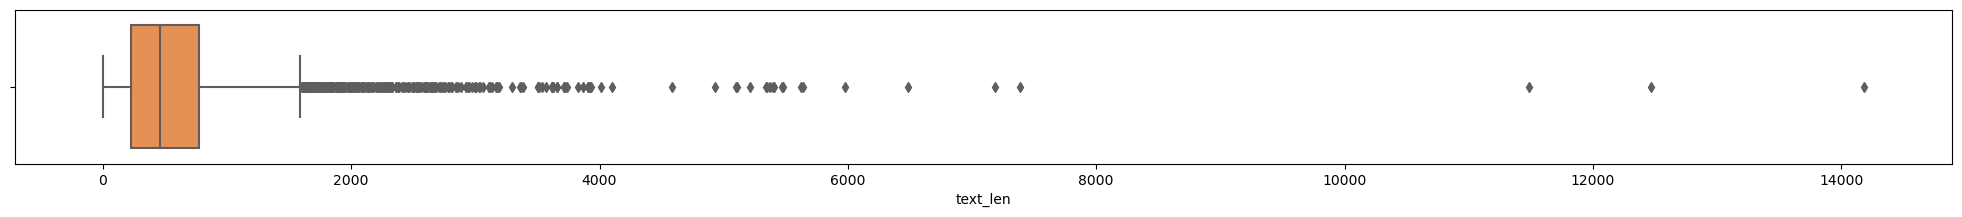

In [13]:
text_len = [len(word) for word in df['clean_text'].str.split(' ')]
df['text_len'] = pd.DataFrame(text_len)

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x = df['text_len'], palette = "Oranges")

### 4.2. Remove Outliers based on label

In [15]:
print(df['text_len'].quantile(0.25))
print(df['text_len'].quantile(0.75))

224.5
774.0


<Axes: xlabel='text_len'>

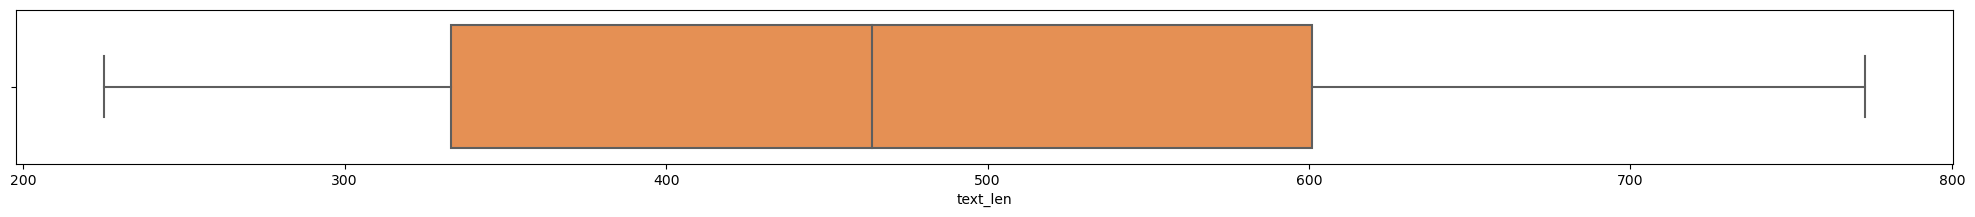

In [16]:
Q1 = df['text_len'].quantile(0.25)
Q3 = df['text_len'].quantile(0.75)
IQR = Q3 - Q1

df = df[(df['text_len'] > Q1) & (df['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x=df['text_len'], palette="Oranges")

# 5. Supervised Learning Model

### 5.1. Split data

In [86]:
X = df['clean_text']
Y = df['label']

x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### 5.2. Initialize a TfidfVectorizer

In [106]:
# Initialize a TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.75)

# Fit and transform train set, transform test set
tfidf_train = tfidf_vectorizer.fit_transform(x_train) 
tfidf_test  = tfidf_vectorizer.transform(x_test)

### 5.3. Training Model

In [107]:
# Initialize a PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)

# Predict on the test set and calculate accuracy
y_pred = np.rint(pac.predict(tfidf_test))
score = accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 89.91%


### 5.4. Confusion Matrix

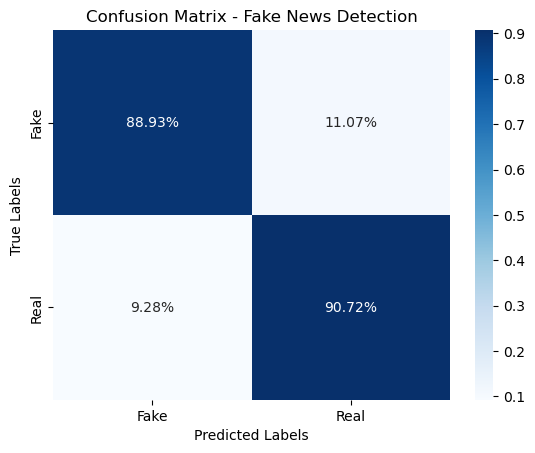

In [109]:
labels = ['Fake', 'Real']

# Build confusion matrix
con_mat = confusion_matrix(y_test,y_pred)

# Compute the percentages for the confusion matrix
cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

# Create the heatmap using Seaborn
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

# 6. Deep Learning Model

### 6.1. Split Train and Test Data

In [17]:
X = df['clean_text']
Y = df['label']
# Y = pd.get_dummies(df_filtered['label'])

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(2220,)
(627,)
(317,)


### 6.2. Model and Tokenizing Configuration

In [18]:
vocab_size = 10000
embedding_dim = 1000
max_length = 775
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [19]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

43542


### 6.3. Build Model

In [43]:
def DNN_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(GlobalAveragePooling1D())

    model.add(Dense(512, kernel_regularizer=keras.regularizers.l2(l=0.1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Dense(128, kernel_regularizer=keras.regularizers.l2(l=0.1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())


    # model.add(Dense(2, activation='softmax'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(LSTM(32))
    model.add(Dropout(0.5))
    # model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(GRU(units=32))
    model.add(Dense(units=1))
    return model

def CuDNNGRU_Model():
    sequences = layers.Input(shape=(max_length,))
    embedded = layers.Embedding(vocab_size, 64)(sequences)
    x = layers.CuDNNGRU(128, return_sequences=True)(embedded)
    x = layers.CuDNNGRU(128)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    return model
    


model = DNN_Model()
# model = LSTM_Model()
# model = GRU_Model()
# model = CuDNNGRU_Model()
# model = RNN_Model()

opt = Adam(learning_rate = 0.00001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['binary_accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

### 6.4. Training Model

In [44]:
num_epoch = 200
batch_size = 64
history = model.fit(training_padded, training_label, 
                    batch_size = batch_size, epochs=num_epoch, 
                    validation_data = (testing_padded, testing_label))

Epoch 1/200
35/35 [==============================] - 2s 33ms/step - loss: 88.5836 - accuracy: 0.5041 - val_loss: 87.7735 - val_accuracy: 0.4673
Epoch 2/200
35/35 [==============================] - 1s 27ms/step - loss: 87.3531 - accuracy: 0.5230 - val_loss: 86.5803 - val_accuracy: 0.4673
Epoch 3/200
35/35 [==============================] - 1s 27ms/step - loss: 86.1379 - accuracy: 0.5446 - val_loss: 85.3997 - val_accuracy: 0.4673
Epoch 4/200
35/35 [==============================] - 1s 27ms/step - loss: 84.9238 - accuracy: 0.5572 - val_loss: 84.2320 - val_accuracy: 0.4673
Epoch 5/200
35/35 [==============================] - 1s 27ms/step - loss: 83.7572 - accuracy: 0.5770 - val_loss: 83.0771 - val_accuracy: 0.4673
Epoch 6/200
35/35 [==============================] - 1s 27ms/step - loss: 82.5966 - accuracy: 0.5838 - val_loss: 81.9372 - val_accuracy: 0.4673
Epoch 7/200
35/35 [==============================] - 1s 27ms/step - loss: 81.4861 - accuracy: 0.5595 - val_loss: 80.8120 - val_accuracy:

### 6.5. Displays Accuracy and Loss

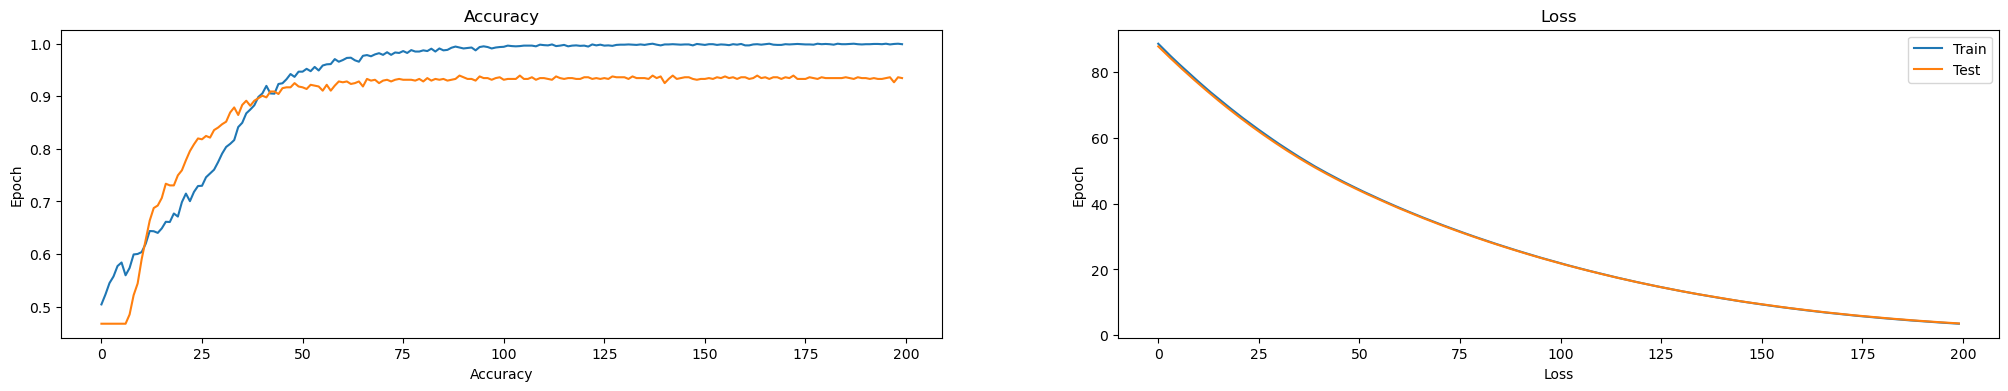

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

### 6.6.Confusion Matrix Neural Network Model

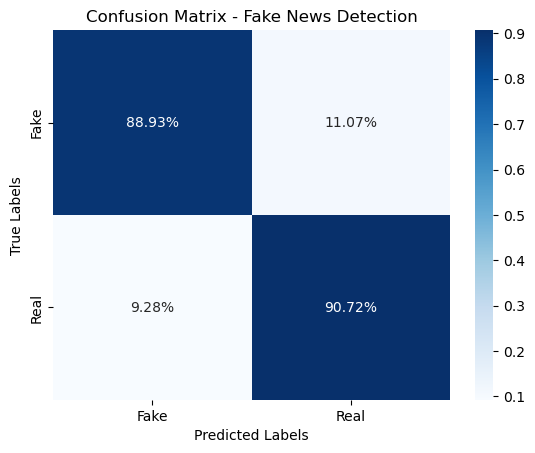

In [114]:
labels = ['Fake', 'Real']

# Build confusion matrix
con_mat = confusion_matrix(y_test,y_pred)

# Compute the percentages for the confusion matrix
cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

# Create the heatmap using Seaborn
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()